In [ ]:
!pip install -q --upgrade accelerate transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00


In [ ]:
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 16.7 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
import pandas as pd
import string
import os

dataset = load_dataset("liar")
df = pd.DataFrame(dataset['train'])
df = df.rename(columns={'label': 'label', 'statement': 'statement'})
unique_labels = df['label'].unique()
print("Unique labels:", unique_labels)

# Preprocess the statements: removing punctuation
df['statement'] = df['statement'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
print(df.head(3))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/10269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1283 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1284 [00:00<?, ? examples/s]

Unique labels: [0 1 2 3 4 5]
           id  label                                          statement  \
0   2635.json      0  Says the Annies List political group supports ...   
1  10540.json      1  When did the decline of coal start It started ...   
2    324.json      2  Hillary Clinton agrees with John McCain by vot...   

                              subject         speaker             job_title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   

  state_info party_affiliation  barely_true_counts  false_counts  \
0      Texas        republican                 0.0           1.0   
1   Virginia          democrat                 0.0           0.0   
2   Illinois          democrat                70.0          71.0   

   half_true_counts  mostly_true_counts  pants_on_fire_counts          context  

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from accelerate import init_empty_weights
from accelerate.utils import load_and_quantize_model, BnbQuantizationConfig
from accelerate import Accelerator
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

### Surprisal Values ###
model_name = 'google/gemma-2b'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
#gemma_model = AutoModelForCausalLM.from_pretrained(model_name)
gemma_model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
gemma_tokenizer = AutoTokenizer.from_pretrained(model_name)

def compute_surprisal(statement):
    tokenize_input = gemma_tokenizer.tokenize(statement)
    tensor_input = torch.tensor([gemma_tokenizer.convert_tokens_to_ids(tokenize_input)])
    with torch.no_grad():
        outputs = gemma_model(tensor_input, labels=tensor_input)
    loss, logits = outputs[:2]
    return loss.item()  # The loss is the negative log likelihood

def extract_surprisal_values(statement):
    words = statement.split()
    surprisal_values = []
    for i in range(1, len(words) + 1):
        sub_statement = ' '.join(words[:i])
        surprisal = compute_surprisal(sub_statement)
        surprisal_values.append(surprisal)
    return surprisal_values

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

In [ ]:
max_len = 0

# Iterate over the statements in your dataset
for statement in df['statement']:
    # Tokenize the statement
    tokens = gemma_tokenizer.tokenize(statement)

    # Update max_len if the current sequence is longer
    max_len = max(max_len, len(tokens))

print(f"The longest sequence has {max_len} tokens.")

The longest sequence has 87 tokens.


In [ ]:
statement = "The movie was fantastic and thrilling."

surprisal_values = extract_surprisal_values(statement)
print(f"Surprisal values: {surprisal_values}")

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import string
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

In [ ]:
 # Check available GPU devices and print out their names
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
    device = torch.device("cuda:0")  # Assuming you use the first GPU if available
else:
    device = torch.device("cpu")

print(f'Using device: {device}')

Device 0: NVIDIA A100-SXM4-40GB
Using device: cuda:0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

max_length_1 = 87

def generate_features(statement, device):
    # Tokenize the statement and ensure the input is on the correct device
    #inputs = gemma_tokenizer(statement, return_tensors="pt", max_length=max_length, truncation=True, pad_to_max_length=True)
    inputs = gemma_tokenizer(statement, return_tensors="pt", max_length=max_length_1, truncation=True, pad_to_max_length=False)
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = gemma_model(**inputs, output_hidden_states=True)

    # Extract embeddings and ensure they are on the correct device
    embeddings = outputs.hidden_states[-1].squeeze(0).to(device) #  the last layer's hidden states, which are typically used as the token embeddings.

    surprisal_values = []
    for i in range(1, len(inputs['input_ids'][0])):
        sub_input = inputs['input_ids'][:, :i + 1].to(device)
        sub_labels = sub_input.clone().to(device)

        with torch.no_grad():
            outputs = gemma_model(sub_input, labels=sub_labels)

        loss = outputs.loss
        surprisal_values.append(loss.item())

    # Ensure surprisal_values length matches embeddings' sequence length
    surprisal_values += [0] * (embeddings.size(0) - len(surprisal_values))

    # Create a tensor for surprisal values and ensure it's on the correct device
    surprisal_tensor = torch.tensor(surprisal_values, device=device).unsqueeze(1)

    # Ensure the surprisal_tensor is the same length as embeddings
    if surprisal_tensor.size(0) < embeddings.size(0):
        padding = torch.zeros((embeddings.size(0) - surprisal_tensor.size(0), 1), device=device)
        surprisal_tensor = torch.cat((surprisal_tensor, padding), dim=0)

    # Concatenate embeddings and surprisal values
    features = torch.cat((embeddings, surprisal_tensor), dim=1)
    return features

# Sample 1% of the data
df_sampled = df.sample(frac=0.5, random_state=42)

label_to_int = {label: idx for idx, label in enumerate(df_sampled['label'].unique())}
df_sampled['encoded_labels'] = df_sampled['label'].apply(lambda x: label_to_int[x])
train_labels = df_sampled['encoded_labels'].tolist()


'''
label_to_int = {label: idx for idx, label in enumerate(df['label'].unique())}
df['encoded_labels'] = df['label'].apply(lambda x: label_to_int[x])
train_labels = df['encoded_labels'].tolist()
'''

# Generate features and encode labels for the sampled training data
train_features = []
for statement in tqdm(df_sampled['statement'], desc="Generating features"):
#for statement in tqdm(df['statement'], desc="Generating features"):
    train_features.append(generate_features(statement, device))


print("Feature tensor shape:", train_features[0].shape)
print("Feature tensor example:\n", train_features[0])

# if an embedding vector is [e1, e2, ..., e2048] for a token,
# and its surprisal value is s1, after concatenation, the representation
# for this token will be [e1, e2, ..., e2048, s1].


Using device: cuda


Generating features: 100%|██████████| 5134/5134 [2:04:34<00:00,  1.46s/it]

Feature tensor shape: torch.Size([7, 2049])
Feature tensor example:
 tensor([[ 0.3452, -0.7583,  0.2546,  ...,  0.1165,  0.0139,  3.3437],
        [ 0.6353, -0.5566,  0.4763,  ...,  0.3464,  0.6611,  7.0030],
        [-0.8359,  0.9956, -0.1169,  ..., -0.0280,  0.4685,  6.2892],
        ...,
        [ 0.6318,  0.1350,  0.5210,  ..., -0.4333,  1.5156,  4.7176],
        [ 0.3872,  0.3730,  0.5625,  ...,  0.5034,  0.1826,  4.8529],
        [-0.3396,  0.9312, -1.0273,  ...,  0.6094,  1.1846,  0.0000]],
       device='cuda:0')


In [ ]:
# Convert training data to PyTorch tensors and create DataLoader
# train_data = TensorDataset(torch.stack(train_features), torch.tensor(train_labels))
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

val_data = pd.DataFrame(dataset['validation'])
val_data = val_data.rename(columns={'label': 'label', 'statement': 'statement'})
val_data['statement'] = val_data['statement'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
val_data_sampled = val_data.sample(frac=0.4, random_state=1)
val_features = [generate_features(statement, device) for statement in val_data_sampled['statement']]
# Handle labels that might not be in the label_to_int dictionary
val_labels = [label_to_int.get(label, -1) for label in val_data_sampled['label']]

# Find the maximum length across both training and validation features
max_length_train = max([feature.shape[0] for feature in train_features])
max_length_val = max([feature.shape[0] for feature in val_features])
max_length = max(max_length_train, max_length_val)

# Pad the training and validation features to the same max_length
padded_train_features = [torch.nn.functional.pad(feature, (0, 0, 0, max_length - feature.size(0))) for feature in train_features]
padded_val_features = [torch.nn.functional.pad(feature, (0, 0, 0, max_length - feature.size(0))) for feature in val_features]

# Convert the list of padded features to tensors
padded_train_features_tensor = torch.stack(padded_train_features)
padded_val_features_tensor = torch.stack(padded_val_features)

# Create TensorDatasets and DataLoaders
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long, device=device)
train_dataset = TensorDataset(padded_train_features_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_labels_tensor = torch.tensor(val_labels, dtype=torch.long, device=device)
val_dataset = TensorDataset(padded_val_features_tensor, val_labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


######### Test dataset ############
test_data = pd.DataFrame(dataset['test'])
test_data = test_data.rename(columns={'label': 'label', 'statement': 'statement'})
test_data['statement'] = test_data['statement'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
test_data_sampled = test_data.sample(frac=0.4, random_state=1)
test_features = [generate_features(statement, device) for statement in test_data_sampled['statement']]
# Handle labels that might not be in the label_to_int dictionary
test_labels = [label_to_int.get(label, -1) for label in test_data_sampled['label']]

# Pad the test feature vectors to the same max_length
padded_test_features = [torch.nn.functional.pad(feature, (0, 0, 0, max_length - feature.size(0))) for feature in test_features]

# Convert the list of padded features to a tensor
padded_test_features_tensor = torch.stack(padded_test_features)

# Convert test labels to a tensor
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long, device=device)

# Create a TensorDataset and DataLoader for the test set
test_dataset = TensorDataset(padded_test_features_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

Epoch 1/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 842.19it/s]


Epoch 1/20, Train Loss: 1.7718, Train Accuracy: 0.2104, Val Loss: 1.7366, Val Accuracy: 0.2179


Epoch 2/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 841.51it/s]


Epoch 2/20, Train Loss: 1.6821, Train Accuracy: 0.2840, Val Loss: 1.7497, Val Accuracy: 0.2140


Epoch 3/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 839.39it/s]


Epoch 3/20, Train Loss: 1.6179, Train Accuracy: 0.3309, Val Loss: 1.7477, Val Accuracy: 0.2315


Epoch 4/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 845.90it/s]


Epoch 4/20, Train Loss: 1.5299, Train Accuracy: 0.3935, Val Loss: 1.7461, Val Accuracy: 0.2432


Epoch 5/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 827.00it/s]


Epoch 5/20, Train Loss: 1.3952, Train Accuracy: 0.4764, Val Loss: 1.7497, Val Accuracy: 0.2335


Epoch 6/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 844.91it/s]


Epoch 6/20, Train Loss: 1.2399, Train Accuracy: 0.5660, Val Loss: 1.8538, Val Accuracy: 0.2510


Epoch 7/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 852.59it/s]


Epoch 7/20, Train Loss: 1.0719, Train Accuracy: 0.6356, Val Loss: 1.8797, Val Accuracy: 0.2471


Epoch 8/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 866.18it/s]


Epoch 8/20, Train Loss: 0.8471, Train Accuracy: 0.7411, Val Loss: 1.8676, Val Accuracy: 0.2315


Epoch 9/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 823.73it/s]


Epoch 9/20, Train Loss: 0.6973, Train Accuracy: 0.8009, Val Loss: 2.0743, Val Accuracy: 0.2315


Epoch 10/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 819.38it/s]


Epoch 10/20, Train Loss: 0.5216, Train Accuracy: 0.8685, Val Loss: 2.3093, Val Accuracy: 0.2004


Epoch 11/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 829.10it/s]


Epoch 11/20, Train Loss: 0.4101, Train Accuracy: 0.9001, Val Loss: 2.2179, Val Accuracy: 0.2354


Epoch 12/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 842.49it/s]


Epoch 12/20, Train Loss: 0.3285, Train Accuracy: 0.9254, Val Loss: 2.2439, Val Accuracy: 0.2160


Epoch 13/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 799.14it/s]


Epoch 13/20, Train Loss: 0.2505, Train Accuracy: 0.9507, Val Loss: 2.3088, Val Accuracy: 0.2160


Epoch 14/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 812.51it/s]


Epoch 14/20, Train Loss: 0.2150, Train Accuracy: 0.9546, Val Loss: 2.3752, Val Accuracy: 0.2257


Epoch 15/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 871.89it/s]


Epoch 15/20, Train Loss: 0.1675, Train Accuracy: 0.9692, Val Loss: 2.4432, Val Accuracy: 0.2101


Epoch 16/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 822.70it/s]


Epoch 16/20, Train Loss: 0.1561, Train Accuracy: 0.9684, Val Loss: 2.4746, Val Accuracy: 0.2374


Epoch 17/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 845.28it/s]


Epoch 17/20, Train Loss: 0.1403, Train Accuracy: 0.9720, Val Loss: 2.2849, Val Accuracy: 0.2412


Epoch 18/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 767.98it/s]


Epoch 18/20, Train Loss: 0.1186, Train Accuracy: 0.9795, Val Loss: 2.6034, Val Accuracy: 0.2218


Epoch 19/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 825.57it/s]


Epoch 19/20, Train Loss: 0.1140, Train Accuracy: 0.9782, Val Loss: 2.4934, Val Accuracy: 0.2568


Epoch 20/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 851.42it/s]


Epoch 20/20, Train Loss: 0.1278, Train Accuracy: 0.9712, Val Loss: 2.6771, Val Accuracy: 0.2393
Test loss: 2.803.. Test accuracy: 0.244


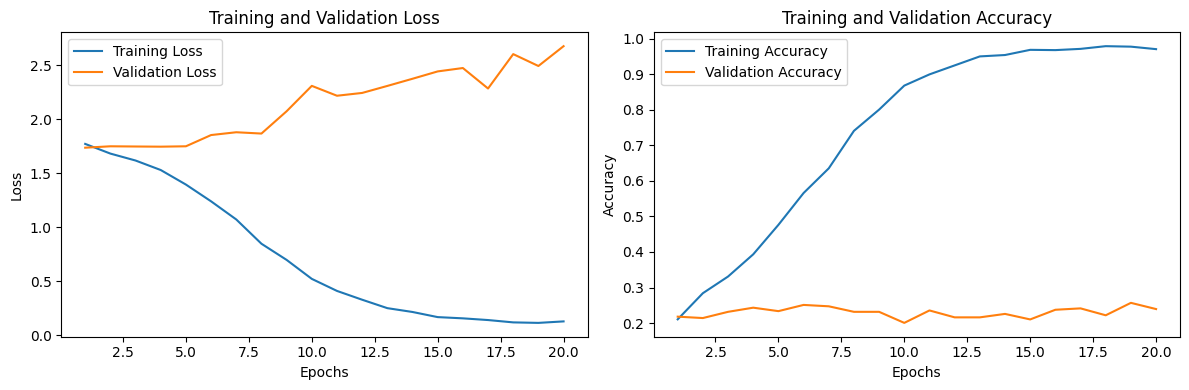

In [ ]:
# Define a CNN model
'''
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2049, out_channels=128, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=5, stride=5)  # Ensure stride is defined

        # Dynamically calculate flattened size
        self.flattened_size = 128 * 12  # Update this based on the actual output from the pooling layer

        self.fc1 = nn.Linear(self.flattened_size, 64)  # Update the input size here
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        #print(f"Input shape: {x.shape}")
        x = self.conv1(x)
        #print(f"After conv1 shape: {x.shape}")
        x = self.relu(x)
        x = self.pool(x)
        #print(f"After pooling shape: {x.shape}")

        x = x.view(x.size(0), -1)
        #print(f"After flattening shape: {x.shape}")
        x = self.fc1(x)
        #print(f"After fc1 shape: {x.shape}")
        x = self.fc2(x)
        #print(f"Output shape: {x.shape}")
        return x
'''
import torch.nn.functional as F

'''
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2049, out_channels=128, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=5, stride=5)

        # Placeholder for the flattened size (to be updated dynamically if needed)
        self.flattened_size = None  # This will be set dynamically based on input

        self.fc1 = None  # Placeholder for the first fully connected layer, will be initialized later
        self.fc2 = nn.Linear(64, num_classes)  # Initialization of fc2, assuming fc1's output size is 64

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))

        # Dynamically calculate flattened size if not set
        if self.fc1 is None:
            self.flattened_size = x.shape[1] * x.shape[2]  # Compute the flattened size
            self.fc1 = nn.Linear(self.flattened_size, 64).to(x.device)  # Initialize fc1 dynamically on the correct device

        x = x.view(-1, self.flattened_size)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
'''

class CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2049, out_channels=128, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(num_features=128)  # Batch normalization after convolution
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=5, stride=5)
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout layer

        # Placeholder for the flattened size (to be updated dynamically if needed)
        self.flattened_size = None  # This will be set dynamically based on input

        self.fc1 = None  # Placeholder for the first fully connected layer, will be initialized later
        self.bn2 = None  # Placeholder for batch normalization, will be initialized later
        self.fc2 = nn.Linear(64, num_classes)  # Initialization of fc2, assuming fc1's output size is 64

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)

        # Dynamically calculate flattened size if not set
        if self.fc1 is None:
            self.flattened_size = x.shape[1] * x.shape[2]  # Compute the flattened size
            self.fc1 = nn.Linear(self.flattened_size, 64).to(x.device)  # Initialize fc1 dynamically on the correct device
            self.bn2 = nn.BatchNorm1d(num_features=64).to(x.device)  # Initialize batch normalization for fc1

        x = x.view(-1, self.flattened_size)  # Flatten the output for the fully connected layer
        x = self.dropout(F.relu(self.bn2(self.fc1(x))))  # Apply BN, ReLU, and dropout sequentially
        x = self.fc2(x)
        return x


# Instantiate the model, define loss function and optimizer
# model = CNN().to(device)
model = CNN(num_classes=len(label_to_int)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} - Training'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.transpose(1, 2))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation loop with progress bar
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        # Wrap the val_loader with tqdm for a progress bar
        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} - Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.transpose(1, 2))
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(total_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")


# Evaluate the model on the test data
model.eval()
test_loss = 0.0
correct_preds = 0
total_preds = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.transpose(1, 2))
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

test_loss /= len(test_loader)
test_acc = correct_preds / total_preds

print(f"Test loss: {test_loss:.3f}.. Test accuracy: {test_acc:.3f}")

plt.figure(figsize=(12, 4))

epochs_range = range(1, epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1032.80it/s]


Epoch 1/20, Train Loss: 1.7846, Train Accuracy: 0.2037, Val Loss: 1.7449, Val Accuracy: 0.2296


Epoch 2/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 947.44it/s]


Epoch 2/20, Train Loss: 1.7428, Train Accuracy: 0.2281, Val Loss: 1.7350, Val Accuracy: 0.2374


Epoch 3/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 784.38it/s]


Epoch 3/20, Train Loss: 1.7158, Train Accuracy: 0.2429, Val Loss: 1.7396, Val Accuracy: 0.2549


Epoch 4/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 984.56it/s]


Epoch 4/20, Train Loss: 1.7020, Train Accuracy: 0.2593, Val Loss: 1.7256, Val Accuracy: 0.2412


Epoch 5/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1029.25it/s]


Epoch 5/20, Train Loss: 1.6863, Train Accuracy: 0.2600, Val Loss: 1.7224, Val Accuracy: 0.2471


Epoch 6/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1013.81it/s]


Epoch 6/20, Train Loss: 1.6729, Train Accuracy: 0.2748, Val Loss: 1.7009, Val Accuracy: 0.2529


Epoch 7/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 998.49it/s]


Epoch 7/20, Train Loss: 1.6497, Train Accuracy: 0.2947, Val Loss: 1.7273, Val Accuracy: 0.2626


Epoch 8/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1010.45it/s]


Epoch 8/20, Train Loss: 1.6304, Train Accuracy: 0.3078, Val Loss: 1.7148, Val Accuracy: 0.2549


Epoch 9/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1002.73it/s]


Epoch 9/20, Train Loss: 1.5986, Train Accuracy: 0.3303, Val Loss: 1.7128, Val Accuracy: 0.2451


Epoch 10/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 993.36it/s]


Epoch 10/20, Train Loss: 1.5698, Train Accuracy: 0.3434, Val Loss: 1.7276, Val Accuracy: 0.2471


Epoch 11/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 993.50it/s]


Epoch 11/20, Train Loss: 1.5384, Train Accuracy: 0.3619, Val Loss: 1.7464, Val Accuracy: 0.2451


Epoch 12/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 993.44it/s]


Epoch 12/20, Train Loss: 1.5070, Train Accuracy: 0.3798, Val Loss: 1.7248, Val Accuracy: 0.2490


Epoch 13/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1064.34it/s]


Epoch 13/20, Train Loss: 1.4684, Train Accuracy: 0.4059, Val Loss: 1.7652, Val Accuracy: 0.2315


Epoch 14/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1033.41it/s]


Epoch 14/20, Train Loss: 1.4288, Train Accuracy: 0.4176, Val Loss: 1.7405, Val Accuracy: 0.2412


Epoch 15/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1035.89it/s]


Epoch 15/20, Train Loss: 1.3725, Train Accuracy: 0.4531, Val Loss: 1.7181, Val Accuracy: 0.2529


Epoch 16/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 998.45it/s]


Epoch 16/20, Train Loss: 1.3499, Train Accuracy: 0.4603, Val Loss: 1.7588, Val Accuracy: 0.2451


Epoch 17/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 997.14it/s]


Epoch 17/20, Train Loss: 1.2997, Train Accuracy: 0.4864, Val Loss: 1.8017, Val Accuracy: 0.2588


Epoch 18/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 996.33it/s]


Epoch 18/20, Train Loss: 1.2504, Train Accuracy: 0.5099, Val Loss: 1.7366, Val Accuracy: 0.2315


Epoch 19/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 981.96it/s]


Epoch 19/20, Train Loss: 1.2132, Train Accuracy: 0.5294, Val Loss: 1.7553, Val Accuracy: 0.2471


Epoch 20/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 982.69it/s]


Epoch 20/20, Train Loss: 1.1750, Train Accuracy: 0.5473, Val Loss: 1.8222, Val Accuracy: 0.2471
Test loss: 1.893.. Test accuracy: 0.238


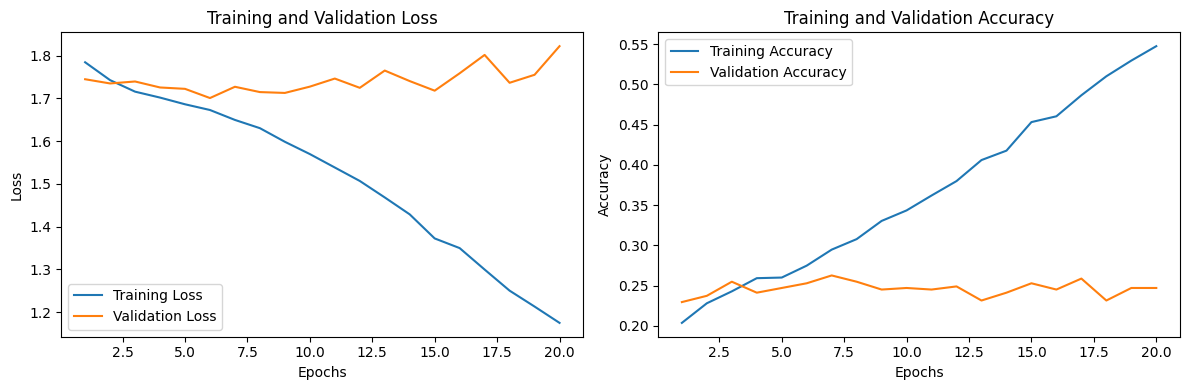

In [ ]:
# Define a CNN model
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2049, out_channels=128, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=5, stride=5)
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout layer

        # Placeholder for the flattened size (to be updated dynamically if needed)
        self.flattened_size = None  # This will be set dynamically based on input

        self.fc1 = None  # Placeholder for the first fully connected layer, will be initialized later
        self.fc2 = nn.Linear(64, num_classes)  # Initialization of fc2, assuming fc1's output size is 64

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.dropout(x)  # Apply dropout after pooling

        # Dynamically calculate flattened size if not set
        if self.fc1 is None:
            self.flattened_size = x.shape[1] * x.shape[2]  # Compute the flattened size
            self.fc1 = nn.Linear(self.flattened_size, 64).to(x.device)  # Initialize fc1 dynamically on the correct device

        x = x.view(-1, self.flattened_size)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = self.fc2(x)
        return x

# Instantiate the model, define loss function and optimizer
# model = CNN().to(device)
model = CNN(num_classes=len(label_to_int)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} - Training'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.transpose(1, 2))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation loop with progress bar
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        # Wrap the val_loader with tqdm for a progress bar
        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} - Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.transpose(1, 2))
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(total_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")


# Evaluate the model on the test data
model.eval()
test_loss = 0.0
correct_preds = 0
total_preds = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.transpose(1, 2))
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

test_loss /= len(test_loader)
test_acc = correct_preds / total_preds

print(f"Test loss: {test_loss:.3f}.. Test accuracy: {test_acc:.3f}")

plt.figure(figsize=(12, 4))

epochs_range = range(1, epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 987.14it/s]


Epoch 1/20, Train Loss: 1.7868, Train Accuracy: 0.2084, Val Loss: 1.7354, Val Accuracy: 0.2432


Epoch 2/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1010.15it/s]


Epoch 2/20, Train Loss: 1.7374, Train Accuracy: 0.2386, Val Loss: 1.7271, Val Accuracy: 0.2335


Epoch 3/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 970.88it/s]


Epoch 3/20, Train Loss: 1.7008, Train Accuracy: 0.2616, Val Loss: 1.7234, Val Accuracy: 0.2490


Epoch 4/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 970.02it/s]


Epoch 4/20, Train Loss: 1.6743, Train Accuracy: 0.2752, Val Loss: 1.7312, Val Accuracy: 0.2646


Epoch 5/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 969.44it/s]


Epoch 5/20, Train Loss: 1.6438, Train Accuracy: 0.2929, Val Loss: 1.7410, Val Accuracy: 0.2510


Epoch 6/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 958.75it/s]


Epoch 6/20, Train Loss: 1.5876, Train Accuracy: 0.3344, Val Loss: 1.7441, Val Accuracy: 0.2510


Epoch 7/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 996.55it/s]


Epoch 7/20, Train Loss: 1.5347, Train Accuracy: 0.3603, Val Loss: 1.7809, Val Accuracy: 0.2412


Epoch 8/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1011.42it/s]


Epoch 8/20, Train Loss: 1.4581, Train Accuracy: 0.4182, Val Loss: 1.7514, Val Accuracy: 0.2607


Epoch 9/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 986.69it/s]


Epoch 9/20, Train Loss: 1.3813, Train Accuracy: 0.4595, Val Loss: 1.7390, Val Accuracy: 0.2510


Epoch 10/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 996.05it/s]


Epoch 10/20, Train Loss: 1.2747, Train Accuracy: 0.5084, Val Loss: 1.8050, Val Accuracy: 0.2451


Epoch 11/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 954.27it/s]


Epoch 11/20, Train Loss: 1.1960, Train Accuracy: 0.5413, Val Loss: 1.8698, Val Accuracy: 0.2568


Epoch 12/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1017.88it/s]


Epoch 12/20, Train Loss: 1.0892, Train Accuracy: 0.5941, Val Loss: 1.9298, Val Accuracy: 0.2160


Epoch 13/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1012.05it/s]


Epoch 13/20, Train Loss: 0.9856, Train Accuracy: 0.6441, Val Loss: 1.9126, Val Accuracy: 0.2335


Epoch 14/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1023.15it/s]


Epoch 14/20, Train Loss: 0.9066, Train Accuracy: 0.6895, Val Loss: 2.0065, Val Accuracy: 0.2237


Epoch 15/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1035.25it/s]


Epoch 15/20, Train Loss: 0.8137, Train Accuracy: 0.7187, Val Loss: 2.0724, Val Accuracy: 0.2335


Epoch 16/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1020.15it/s]


Epoch 16/20, Train Loss: 0.7268, Train Accuracy: 0.7565, Val Loss: 2.2784, Val Accuracy: 0.2198


Epoch 17/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1011.46it/s]


Epoch 17/20, Train Loss: 0.6363, Train Accuracy: 0.7949, Val Loss: 2.2787, Val Accuracy: 0.2218


Epoch 18/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 987.00it/s]


Epoch 18/20, Train Loss: 0.5810, Train Accuracy: 0.8171, Val Loss: 2.2960, Val Accuracy: 0.2257


Epoch 19/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 974.15it/s]


Epoch 19/20, Train Loss: 0.5275, Train Accuracy: 0.8309, Val Loss: 2.4836, Val Accuracy: 0.2276


Epoch 20/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 725.93it/s]


Epoch 20/20, Train Loss: 0.4650, Train Accuracy: 0.8568, Val Loss: 2.3946, Val Accuracy: 0.2023
Test loss: 2.517.. Test accuracy: 0.248


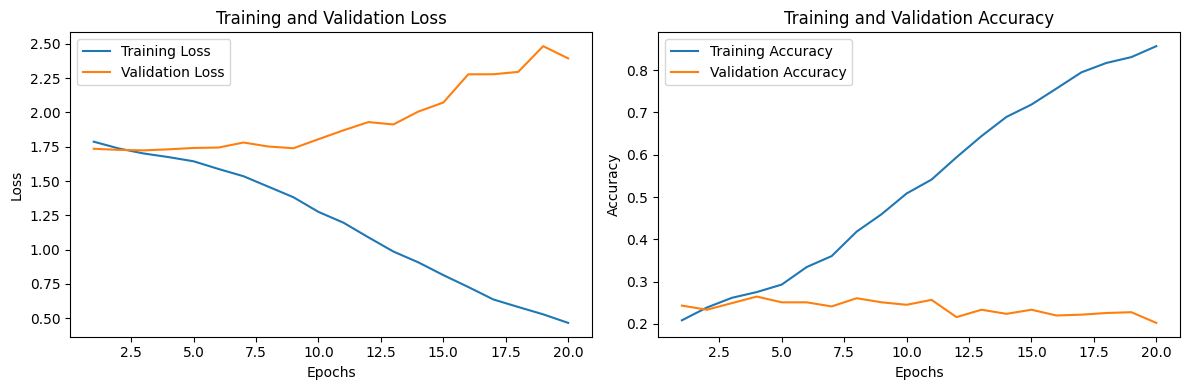

In [ ]:
# Define a CNN model
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2049, out_channels=128, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=5, stride=5)
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout layer

        # Placeholder for the flattened size (to be updated dynamically if needed)
        self.flattened_size = None  # This will be set dynamically based on input

        self.fc1 = None  # Placeholder for the first fully connected layer, will be initialized later
        self.fc2 = nn.Linear(64, num_classes)  # Initialization of fc2, assuming fc1's output size is 64

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.dropout(x)  # Apply dropout after pooling

        # Dynamically calculate flattened size if not set
        if self.fc1 is None:
            self.flattened_size = x.shape[1] * x.shape[2]  # Compute the flattened size
            self.fc1 = nn.Linear(self.flattened_size, 64).to(x.device)  # Initialize fc1 dynamically on the correct device

        x = x.view(-1, self.flattened_size)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = self.fc2(x)
        return x

# Instantiate the model, define loss function and optimizer
# model = CNN().to(device)
model = CNN(num_classes=len(label_to_int)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} - Training'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.transpose(1, 2))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation loop with progress bar
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        # Wrap the val_loader with tqdm for a progress bar
        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} - Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.transpose(1, 2))
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(total_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")


# Evaluate the model on the test data
model.eval()
test_loss = 0.0
correct_preds = 0
total_preds = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.transpose(1, 2))
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

test_loss /= len(test_loader)
test_acc = correct_preds / total_preds

print(f"Test loss: {test_loss:.3f}.. Test accuracy: {test_acc:.3f}")

plt.figure(figsize=(12, 4))

epochs_range = range(1, epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 986.85it/s]


Epoch 1/20, Train Loss: 2.0414, Train Accuracy: 0.2071, Val Loss: 1.7847, Val Accuracy: 0.2023


Epoch 2/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 998.27it/s]


Epoch 2/20, Train Loss: 1.7614, Train Accuracy: 0.2061, Val Loss: 1.7698, Val Accuracy: 0.1984


Epoch 3/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 981.08it/s]


Epoch 3/20, Train Loss: 1.7403, Train Accuracy: 0.2207, Val Loss: 1.7430, Val Accuracy: 0.2432


Epoch 4/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 910.87it/s]


Epoch 4/20, Train Loss: 1.7100, Train Accuracy: 0.2394, Val Loss: 1.7450, Val Accuracy: 0.2062


Epoch 5/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 647.68it/s]


Epoch 5/20, Train Loss: 1.6936, Train Accuracy: 0.2423, Val Loss: 1.7177, Val Accuracy: 0.2451


Epoch 6/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 883.18it/s]


Epoch 6/20, Train Loss: 1.6767, Train Accuracy: 0.2559, Val Loss: 1.7460, Val Accuracy: 0.2412


Epoch 7/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1002.08it/s]


Epoch 7/20, Train Loss: 1.6637, Train Accuracy: 0.2534, Val Loss: 1.7604, Val Accuracy: 0.2451


Epoch 8/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1020.73it/s]


Epoch 8/20, Train Loss: 1.6568, Train Accuracy: 0.2544, Val Loss: 1.7584, Val Accuracy: 0.2549


Epoch 9/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 997.40it/s]


Epoch 9/20, Train Loss: 1.6273, Train Accuracy: 0.2743, Val Loss: 1.7263, Val Accuracy: 0.2510


Epoch 10/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1005.69it/s]


Epoch 10/20, Train Loss: 1.6135, Train Accuracy: 0.2793, Val Loss: 1.7503, Val Accuracy: 0.2549


Epoch 11/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 976.74it/s]


Epoch 11/20, Train Loss: 1.6044, Train Accuracy: 0.2857, Val Loss: 1.7355, Val Accuracy: 0.2529


Epoch 12/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1013.74it/s]


Epoch 12/20, Train Loss: 1.5928, Train Accuracy: 0.2871, Val Loss: 1.7882, Val Accuracy: 0.2315


Epoch 13/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1003.99it/s]


Epoch 13/20, Train Loss: 1.5872, Train Accuracy: 0.2894, Val Loss: 1.7987, Val Accuracy: 0.2335


Epoch 14/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1022.12it/s]


Epoch 14/20, Train Loss: 1.5805, Train Accuracy: 0.2949, Val Loss: 1.7696, Val Accuracy: 0.2354


Epoch 15/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1033.75it/s]


Epoch 15/20, Train Loss: 1.5692, Train Accuracy: 0.2988, Val Loss: 1.8543, Val Accuracy: 0.1946


Epoch 16/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1024.13it/s]


Epoch 16/20, Train Loss: 1.5569, Train Accuracy: 0.3044, Val Loss: 1.8427, Val Accuracy: 0.2490


Epoch 17/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 941.07it/s]


Epoch 17/20, Train Loss: 1.5521, Train Accuracy: 0.3002, Val Loss: 1.7629, Val Accuracy: 0.2393


Epoch 18/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1040.00it/s]


Epoch 18/20, Train Loss: 1.5411, Train Accuracy: 0.3083, Val Loss: 1.8369, Val Accuracy: 0.2296


Epoch 19/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1033.92it/s]


Epoch 19/20, Train Loss: 1.5325, Train Accuracy: 0.3142, Val Loss: 1.8014, Val Accuracy: 0.2198


Epoch 20/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 945.54it/s]


Epoch 20/20, Train Loss: 1.5296, Train Accuracy: 0.3153, Val Loss: 1.7916, Val Accuracy: 0.2471
Test loss: 1.751.. Test accuracy: 0.255


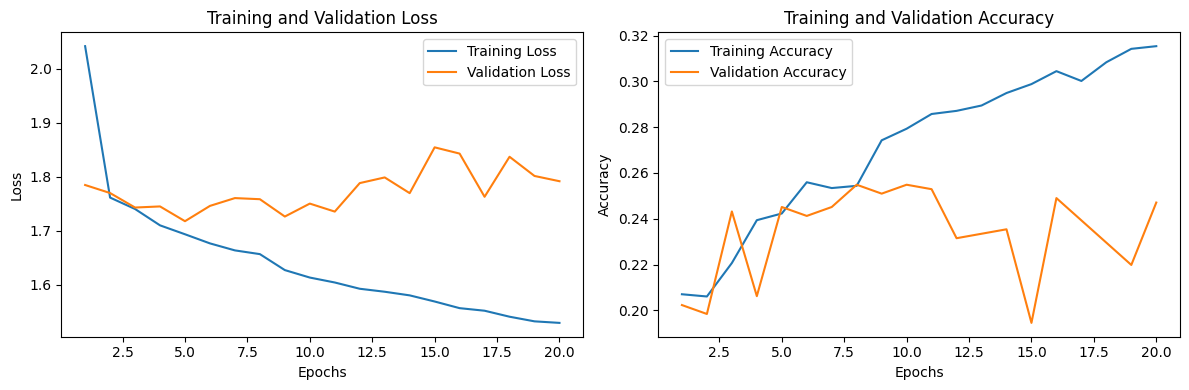

In [ ]:
# Define a CNN model
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2049, out_channels=128, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=5, stride=5)

        # Placeholder for the flattened size (to be updated dynamically if needed)
        self.flattened_size = None  # This will be set dynamically based on input

        self.fc1 = None  # Placeholder for the first fully connected layer, will be initialized later
        self.fc2 = nn.Linear(64, num_classes)  # Initialization of fc2, assuming fc1's output size is 64

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))

        # Dynamically calculate flattened size if not set
        if self.fc1 is None:
            self.flattened_size = x.shape[1] * x.shape[2]  # Compute the flattened size
            self.fc1 = nn.Linear(self.flattened_size, 64).to(x.device)  # Initialize fc1 dynamically on the correct device

        x = x.view(-1, self.flattened_size)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model, define loss function and optimizer
# model = CNN().to(device)
model = CNN(num_classes=len(label_to_int)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)



train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} - Training'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.transpose(1, 2))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation loop with progress bar
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        # Wrap the val_loader with tqdm for a progress bar
        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} - Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.transpose(1, 2))
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(total_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")


# Evaluate the model on the test data
model.eval()
test_loss = 0.0
correct_preds = 0
total_preds = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.transpose(1, 2))
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

test_loss /= len(test_loader)
test_acc = correct_preds / total_preds

print(f"Test loss: {test_loss:.3f}.. Test accuracy: {test_acc:.3f}")

plt.figure(figsize=(12, 4))

epochs_range = range(1, epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 982.80it/s]


Epoch 1/20, Train Loss: 1.7762, Train Accuracy: 0.2226, Val Loss: 1.7561, Val Accuracy: 0.2315


Epoch 2/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1025.53it/s]


Epoch 2/20, Train Loss: 1.7018, Train Accuracy: 0.2704, Val Loss: 1.7581, Val Accuracy: 0.2335


Epoch 3/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1002.24it/s]


Epoch 3/20, Train Loss: 1.6329, Train Accuracy: 0.3187, Val Loss: 1.7756, Val Accuracy: 0.2160


Epoch 4/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1043.22it/s]


Epoch 4/20, Train Loss: 1.5278, Train Accuracy: 0.3911, Val Loss: 1.7854, Val Accuracy: 0.2140


Epoch 5/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 972.94it/s]


Epoch 5/20, Train Loss: 1.3717, Train Accuracy: 0.4846, Val Loss: 1.8347, Val Accuracy: 0.2160


Epoch 6/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1018.46it/s]


Epoch 6/20, Train Loss: 1.1944, Train Accuracy: 0.5719, Val Loss: 1.9166, Val Accuracy: 0.2374


Epoch 7/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1025.68it/s]


Epoch 7/20, Train Loss: 0.9655, Train Accuracy: 0.6958, Val Loss: 2.0083, Val Accuracy: 0.2101


Epoch 8/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1056.99it/s]


Epoch 8/20, Train Loss: 0.7451, Train Accuracy: 0.7933, Val Loss: 2.1493, Val Accuracy: 0.2160


Epoch 9/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1055.01it/s]


Epoch 9/20, Train Loss: 0.5650, Train Accuracy: 0.8629, Val Loss: 2.4599, Val Accuracy: 0.2062


Epoch 10/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1011.79it/s]


Epoch 10/20, Train Loss: 0.3924, Train Accuracy: 0.9270, Val Loss: 2.5321, Val Accuracy: 0.2121


Epoch 11/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1026.31it/s]


Epoch 11/20, Train Loss: 0.2721, Train Accuracy: 0.9630, Val Loss: 2.5376, Val Accuracy: 0.2101


Epoch 12/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1014.34it/s]


Epoch 12/20, Train Loss: 0.1877, Train Accuracy: 0.9811, Val Loss: 2.8716, Val Accuracy: 0.2082


Epoch 13/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 995.73it/s]


Epoch 13/20, Train Loss: 0.1223, Train Accuracy: 0.9940, Val Loss: 2.8928, Val Accuracy: 0.1946


Epoch 14/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1004.40it/s]


Epoch 14/20, Train Loss: 0.0816, Train Accuracy: 0.9984, Val Loss: 3.1226, Val Accuracy: 0.2023


Epoch 15/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1024.41it/s]


Epoch 15/20, Train Loss: 0.0588, Train Accuracy: 0.9988, Val Loss: 3.0505, Val Accuracy: 0.1946


Epoch 16/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1025.33it/s]


Epoch 16/20, Train Loss: 0.0426, Train Accuracy: 0.9992, Val Loss: 3.2149, Val Accuracy: 0.1926


Epoch 17/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 1010.02it/s]


Epoch 17/20, Train Loss: 0.0312, Train Accuracy: 0.9998, Val Loss: 3.3944, Val Accuracy: 0.2004


Epoch 18/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 971.18it/s]


Epoch 18/20, Train Loss: 0.0242, Train Accuracy: 1.0000, Val Loss: 3.3396, Val Accuracy: 0.2082


Epoch 19/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 901.96it/s]


Epoch 19/20, Train Loss: 0.0193, Train Accuracy: 1.0000, Val Loss: 3.3523, Val Accuracy: 0.2101


Epoch 20/20 - Validation: 100%|██████████| 17/17 [00:00<00:00, 971.05it/s]


Epoch 20/20, Train Loss: 0.0156, Train Accuracy: 1.0000, Val Loss: 3.4455, Val Accuracy: 0.2043
Test loss: 3.390.. Test accuracy: 0.230


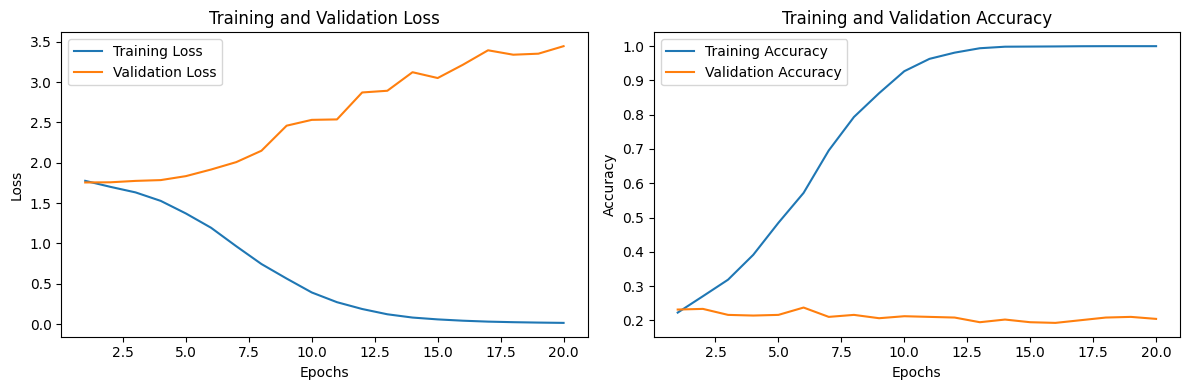

In [ ]:
# Define a CNN model
'''
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2049, out_channels=128, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=5, stride=5)  # Ensure stride is defined

        # Dynamically calculate flattened size
        self.flattened_size = 128 * 12  # Update this based on the actual output from the pooling layer

        self.fc1 = nn.Linear(self.flattened_size, 64)  # Update the input size here
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        #print(f"Input shape: {x.shape}")
        x = self.conv1(x)
        #print(f"After conv1 shape: {x.shape}")
        x = self.relu(x)
        x = self.pool(x)
        #print(f"After pooling shape: {x.shape}")

        x = x.view(x.size(0), -1)
        #print(f"After flattening shape: {x.shape}")
        x = self.fc1(x)
        #print(f"After fc1 shape: {x.shape}")
        x = self.fc2(x)
        #print(f"Output shape: {x.shape}")
        return x
'''
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2049, out_channels=128, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=5, stride=5)

        # Placeholder for the flattened size (to be updated dynamically if needed)
        self.flattened_size = None  # This will be set dynamically based on input

        self.fc1 = None  # Placeholder for the first fully connected layer, will be initialized later
        self.fc2 = nn.Linear(64, num_classes)  # Initialization of fc2, assuming fc1's output size is 64

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))

        # Dynamically calculate flattened size if not set
        if self.fc1 is None:
            self.flattened_size = x.shape[1] * x.shape[2]  # Compute the flattened size
            self.fc1 = nn.Linear(self.flattened_size, 64).to(x.device)  # Initialize fc1 dynamically on the correct device

        x = x.view(-1, self.flattened_size)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model, define loss function and optimizer
# model = CNN().to(device)
model = CNN(num_classes=len(label_to_int)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} - Training'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.transpose(1, 2))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation loop with progress bar
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        # Wrap the val_loader with tqdm for a progress bar
        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} - Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.transpose(1, 2))
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(total_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")


# Evaluate the model on the test data
model.eval()
test_loss = 0.0
correct_preds = 0
total_preds = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.transpose(1, 2))
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

test_loss /= len(test_loader)
test_acc = correct_preds / total_preds

print(f"Test loss: {test_loss:.3f}.. Test accuracy: {test_acc:.3f}")

plt.figure(figsize=(12, 4))

epochs_range = range(1, epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
!nvidia-smi

Epoch 1/3 - Training:   0%|          | 0/1 [00:00<?, ?it/s] <br>
Input shape: torch.Size([10, 2049, 42]) <br>
After conv1 shape: torch.Size([10, 128, 38]) <br>
After pooling shape: torch.Size([10, 128, 7]) <br>
After flattening shape: torch.Size([10, 896]) <br>
After fc1 shape: torch.Size([10, 64]) <br>
Output shape: torch.Size([10, 5]) <br>
Epoch 1/3 - Training: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s] <br>
Epoch 1/3 - Validation:   0%|          | 0/1 [00:00<?, ?it/s] <br> Input shape: torch.Size([10, 2049, 42]) <br>
After conv1 shape: torch.Size([10, 128, 38]) <br>
After pooling shape: torch.Size([10, 128, 7]) <br>
After flattening shape: torch.Size([10, 896]) <br>
After fc1 shape: torch.Size([10, 64]) <br>
Output shape: torch.Size([10, 5]) <br>